# GISAS 
from a distribution of differently oriented square lattices of cylinders on a substrate.


In [1]:
%pylab inline
from time import time
import bornagain as ba
from bornagain import deg, nm, R3
from matplotlib.colors import LogNorm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_result(result, add2=None, div2=None, Imin=1e-9, Imax=None):
    if div2 is None:
        if add2 is None:
            I=result.array()
        else:
            I=result.array()+add2.array()
        imshow(I, norm=LogNorm(Imin, Imax), extent=list(result.axisMinMax(0, ))+list(result.axisMinMax(1)))
    else:
        I=result.array()+div2.array()
        dI=result.array()-div2.array()
        absmax=abs(dI/I).max()
        imshow(dI/I, cmap='seismic', vmin=-absmax, vmax=absmax,
               extent=list(result.axisMinMax(0, ))+list(result.axisMinMax(1)))
        
    xlabel(result.nameOfAxis(0).replace("_f", "$_f$").replace('phi', '$\\phi$'))
    ylabel(result.nameOfAxis(1).replace("_f", "$_f$").replace('alpha', '$\\alpha$'))
    colorbar()

In [3]:
import zipfile
ARCHIVE = 'FeGe.zip'

def read_mm(fname):
    archive = zipfile.ZipFile(ARCHIVE)
    txt = archive.open(fname+'/m000000.gplot', 'r').read().decode('utf-8')
    data = [li.strip().split() for li in txt.splitlines() if li.strip()!='']
    adata= array(data, dtype=float).T
    nx = unique(adata[0]).shape[0]
    ny = unique(adata[1]).shape[0]
    nz = unique(adata[2]).shape[0]
    adata[3:6]*=1.5e5
    adata=adata.reshape(adata.shape[0], nz, ny, nx)
    return adata.transpose(0, 3, 2, 1)

In [4]:
x,y,z,mx,my,mz=read_mm('dia_100')
R=50*nm
xlat=x[:,0,0]*1e9*nm;ylat=y[0,:,0]*1e9*nm;zlat=z[0,0,:]*1e9*nm

In [5]:
phi=0.*deg
def get_sample():
    material_vacuum = ba.MaterialBySLD("Vacuum", 0, 0)
    material_substrate = ba.MaterialBySLD("Substrate", 2e-6, 0e-8)

    toplayer = ba.Layer(material_vacuum)
    substrate = ba.Layer(material_substrate)

    # creates an empty particle composition
    composition = ba.Compound()
    
    dx = xlat[1]-xlat[0]
    dy = ylat[1]-ylat[0]
    dz = (zlat[1]-zlat[0])*(zlat.shape[0]+1)
    
    ff = ba.Box(dx, dy, dz)
    
    for xi,xp in enumerate(xlat):
        for yi,yp in enumerate(ylat):
                Mxyz = R3(mx[xi,yi].mean(), my[xi,yi].mean(), mz[xi,yi].mean())
                if abs(array([mx[xi,yi,0], my[xi,yi,0], mz[xi,yi,0]])).sum()==0.:
                    # ignore empty cells
                    continue
                material = ba.MaterialBySLD("cube_%i_%i"%(xi,yi), 4.4e-6, 0.00033e-6, Mxyz)
                particle = ba.Particle(material, ff.clone())
                composition.addComponent(particle, R3(xp, yp, 0))

    # Define 2D lattices        a     b     gamma   phi
    lattice = ba.BasicLattice2D(6.6*R, 40*R, 90*deg, phi)

    # Define interference functions
    iff = ba.Interference2DLattice(lattice)
    iff_pdf = ba.Profile2DCauchy(500*R, 500*R, phi)
    iff.setDecayFunction(iff_pdf)

    # Define particle layouts
    layout = ba.ParticleLayout(composition)
    layout.setInterference(iff)
    #layout.setTotalParticleSurfaceDensity(0.01/(2*R)**2) # 1/nm² - 1% surface filling in square lattice
    
    toplayer.addLayout(layout)

    sample = ba.MultiLayer()
    sample.addLayer(toplayer)
    sample.addLayer(substrate)
    return sample

def get_reference():
    # single particle with same dimensions and homogeneous magnetization
    material_vacuum = ba.MaterialBySLD("Vacuum", 0, 0)
    material_substrate = ba.MaterialBySLD("Substrate", 2e-6, 0e-8)
    material_particle = ba.MaterialBySLD("Particle", 4.4e-6, 0.00033e-6, R3(0, 0, mx.max()))

    toplayer = ba.Layer(material_vacuum)
    substrate = ba.Layer(material_substrate)

    ff = ba.Cylinder(R, 20*nm)
    
    # Define 2D lattices        a     b     gamma   phi
    lattice = ba.BasicLattice2D(6.6*R, 40*R, 90*deg, 0*deg)

    # Define interference functions
    iff = ba.Interference2DLattice(lattice)
    iff_pdf = ba.Profile2DCauchy(500*R, 500*R, 0*deg)
    iff.setDecayFunction(iff_pdf)

    # Define particle layouts
    particle = ba.Particle(material_particle, ff.clone())
    layout = ba.ParticleLayout(particle)
    layout.setInterference(iff)
    toplayer.addLayout(layout)

    sample = ba.MultiLayer()
    sample.addLayer(toplayer)
    sample.addLayer(substrate)
    return sample

def get_simulation(sample, pol=ba.R3(0, 0, 1), ana=ba.R3(0, 0, -1), n=30):
    beam = ba.Beam(1.0, 0.4*nm, 0.2*deg)
    beam.setPolarization(pol)
    detector = ba.SphericalDetector(n, -1*deg, 1*deg, n, 0, 2*deg)
    detector.setAnalyzer(ana, 1, 0.5)
    simulation = ba.ScatteringSimulation(beam, sample, detector)
    return simulation


In [6]:
start=time()

phi=0.*deg
reference = get_reference()
sample = get_sample()

simulation = get_simulation(reference, pol=ba.R3(0, 0, 1), ana=ba.R3(0, 0, 1))
simulation.options().setNumberOfThreads(8)
resref_pp = simulation.simulate()
simulation = get_simulation(reference, pol=ba.R3(0, 0, -1), ana=ba.R3(0, 0, -1))
simulation.options().setNumberOfThreads(8)
resref_mm = simulation.simulate()

simulation = get_simulation(sample, pol=ba.R3(0, 0, 1), ana=ba.R3(0, 0, 1))
simulation.options().setNumberOfThreads(8)
result_pp = simulation.simulate()
simulation = get_simulation(sample, pol=ba.R3(0, 0, -1), ana=ba.R3(0, 0, -1))
simulation.options().setNumberOfThreads(8)
result_mm = simulation.simulate()

print(time()-start)

21.002424240112305


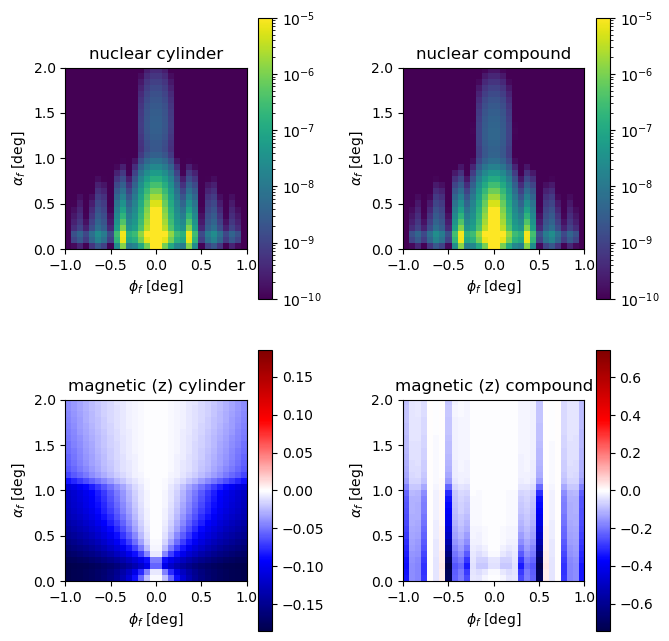

In [17]:
figure(figsize=(7,7))
subplot(221)
title('nuclear cylinder')
plot_result(resref_pp, add2=resref_mm, Imin=1e-10, Imax=1e-5)

subplot(222)
title('nuclear compound')
plot_result(result_pp, add2=result_mm, Imin=1e-10, Imax=1e-5)

subplot(223)
title('magnetic (z) cylinder')
plot_result(resref_pp, div2=resref_mm)

subplot(224)
title('magnetic (z) compound')
plot_result(result_pp, div2=result_mm)

tight_layout(pad=2.0)

In [8]:
phi=0.*deg
sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(1, 0, 0), ana=ba.R3(-1, 0, 0))
simulation.options().setNumberOfThreads(8)
result_udx = simulation.simulate()

In [9]:
sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(-1, 0, 0), ana=ba.R3(1, 0, 0))
simulation.options().setNumberOfThreads(8)
result_dux = simulation.simulate()

In [10]:
sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(0, 1, 0), ana=ba.R3(0, -1, 0))
simulation.options().setNumberOfThreads(8)
result_udy = simulation.simulate()

In [11]:
sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(0, -1, 0), ana=ba.R3(0, 1, 0))
simulation.options().setNumberOfThreads(8)
result_duy = simulation.simulate()

In [12]:
sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(0, 0, 1), ana=ba.R3(0, 0, -1))
simulation.options().setNumberOfThreads(8)
result_udz = simulation.simulate()

In [13]:
sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(0, 0, -1), ana=ba.R3(0, 0, 1))
simulation.options().setNumberOfThreads(8)
result_duz = simulation.simulate()

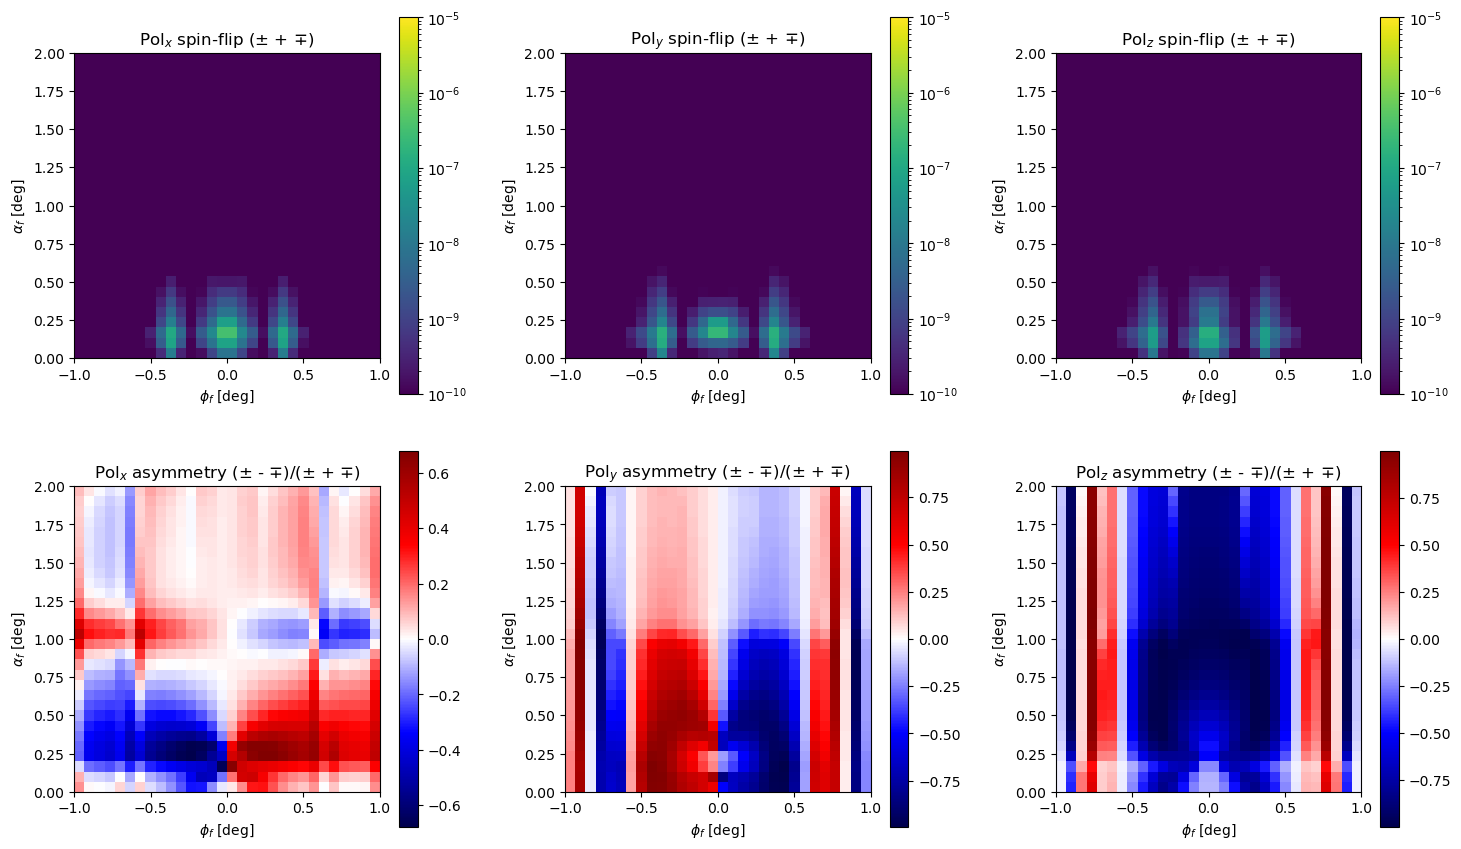

In [18]:
figure(figsize=(15,9))
subplot(231)
title('Pol$_x$ spin-flip (± + ∓)')
plot_result(result_udx, add2=result_dux, Imin=1e-10, Imax=1e-5)
subplot(232)
title('Pol$_y$ spin-flip (± + ∓)')
plot_result(result_udy, add2=result_duy, Imin=1e-10, Imax=1e-5)
subplot(233)
title('Pol$_z$ spin-flip (± + ∓)')
plot_result(result_udz, add2=result_duz, Imin=1e-10, Imax=1e-5)

subplot(234)
title('Pol$_x$ asymmetry (± - ∓)/(± + ∓)')
plot_result(result_udx, div2=result_dux)
subplot(235)
title('Pol$_y$ asymmetry (± - ∓)/(± + ∓)')
plot_result(result_udy, div2=result_duy)
subplot(236)
title('Pol$_z$ asymmetry (± - ∓)/(± + ∓)')
plot_result(result_udz, div2=result_duz)

tight_layout(pad=2.0)

phi=0.45*deg
sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(1, 0, 0), ana=ba.R3(-1, 0, 0))
simulation.options().smetNumberOfThreads(8)
result45_udx = simulation.simulate()

sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(-1, 0, 0), ana=ba.R3(1, 0, 0))
simulation.options().setNumberOfThreads(8)
result45_dux = simulation.simulate()

sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(0, 1, 0), ana=ba.R3(0, -1, 0))
simulation.options().setNumberOfThreads(8)
result45_udy = simulation.simulate()

sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(0, -1, 0), ana=ba.R3(0, 1, 0))
simulation.options().setNumberOfThreads(8)
result45_duy = simulation.simulate()

sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(0, 0, 1), ana=ba.R3(0, 0, -1))
simulation.options().setNumberOfThreads(8)
result45_udz = simulation.simulate()

sample = get_sample()
simulation = get_simulation(sample, pol=ba.R3(0, 0, -1), ana=ba.R3(0, 0, 1))
simulation.options().setNumberOfThreads(8)
result45_duz = simulation.simulate()

figure(figsize=(15,9))
subplot(231)
title('Pol$_x$ spin-flip (± + ∓)')
plot_result(result45_udx, add2=result45_dux, Imin=1e-11, Imax=1e-8)
subplot(232)
title('Pol$_y$ spin-flip (± + ∓)')
plot_result(result45_udy, add2=result45_duy, Imin=1e-11, Imax=1e-8)
subplot(233)
title('Pol$_z$ spin-flip (± + ∓)')
plot_result(result45_udz, add2=result45_duz, Imin=1e-11, Imax=1e-8)

subplot(234)
title('Pol$_x$ asymmetry (± - ∓)/(± + ∓)')
plot_result(result45_udx, div2=result45_dux)
subplot(235)
title('Pol$_y$ asymmetry (± - ∓)/(± + ∓)')
plot_result(result45_udy, div2=result45_duy)
subplot(236)
title('Pol$_z$ asymmetry (± - ∓)/(± + ∓)')
plot_result(result45_udz, div2=result45_duz)

tight_layout(pad=2.0)